### Install Dependencies

In [1]:
!pip install tensorflow scikit-learn matplotlib

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from tensorflow.data import Dataset
from tensorflow import convert_to_tensor, string, float32, shape, range, reshape


### Load Dataset

In [3]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Load dataset
file_path = 'preprocessed_mental_health.csv'
data = pd.read_csv(file_path)

# Drop rows with missing cleaned_text
data = data.dropna(subset=['cleaned_text'])

# Extract features and labels
texts = data['cleaned_text'].astype(str).values
labels = data['mental_health_issue'].astype(str).values


Saving preprocessed_mental_health.csv to preprocessed_mental_health.csv


### Preprocess Labels

In [4]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Get class names
class_names = label_encoder.classes_
print("Classes:", class_names)


Classes: ['anxiety' 'bipolar' 'depression' 'normal' 'ptsd']


### Text Vectorization

In [5]:
# Define parameters
vocab_size = 25000
sequence_length = 300

# Vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length
)

# Adapt vectorizer to texts
vectorize_layer.adapt(Dataset.from_tensor_slices(texts))

# Vectorize text data
texts_vectorized = vectorize_layer(convert_to_tensor(texts, dtype=string))


### Define Transformer Model

In [6]:
class EmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.word_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, tokens):
        sequence_length = shape(tokens)[-1]
        positions = range(start=0, limit=sequence_length, delta=1)
        positions_encoding = self.position_embedding(positions)
        words_encoding = self.word_embedding(tokens)
        return positions_encoding + words_encoding

class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        self.nnw = Sequential([Dense(total_dense_units, activation="relu"), Dense(embed_dim)])
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

# Model parameters
embed_dim = 64
num_heads = 2
total_dense_units = 60

# Define the model
inputs = Input(shape=(sequence_length,))
embedding_layer = EmbeddingLayer(sequence_length, vocab_size, embed_dim)
encoder_layer = EncoderLayer(num_heads, total_dense_units, embed_dim)
emb = embedding_layer(inputs)
enc = encoder_layer(emb)
pool = GlobalAveragePooling1D()(enc)
dense = Dense(total_dense_units, activation="relu")(pool)
outputs = Dense(len(class_names), activation="softmax")(dense)

transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adamw", loss="categorical_crossentropy", metrics=['accuracy'])
transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (EmbeddingLayer)     │ (None, 300, 64)             │       1,619,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer (EncoderLayer)         │ (None, 300, 64)             │          41,148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60)                  │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,664,553 (6.35 MB)

 Trainable params: 1,664,553 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [7]:
# Split data into train and validation
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy

# Convert the TensorFlow tensor to a NumPy array
texts_vectorized_np = texts_vectorized.numpy()

# Now perform the split
X_train, X_val, y_train, y_val = train_test_split(
    texts_vectorized_np, categorical_labels, test_size=0.2, random_state=42
)

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)


Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6216 - loss: 1.0348 - val_accuracy: 0.8624 - val_loss: 0.4073
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8803 - loss: 0.3470 - val_accuracy: 0.8793 - val_loss: 0.3664
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9417 - loss: 0.1821 - val_accuracy: 0.8702 - val_loss: 0.3819
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9748 - loss: 0.0897 - val_accuracy: 0.8583 - val_loss: 0.4721
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9860 - loss: 0.0485 - val_accuracy: 0.8850 - val_loss: 0.4909


### Plot the Random and Learned Embeddings

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Shape of learned_embedding: (1, 300, 64)


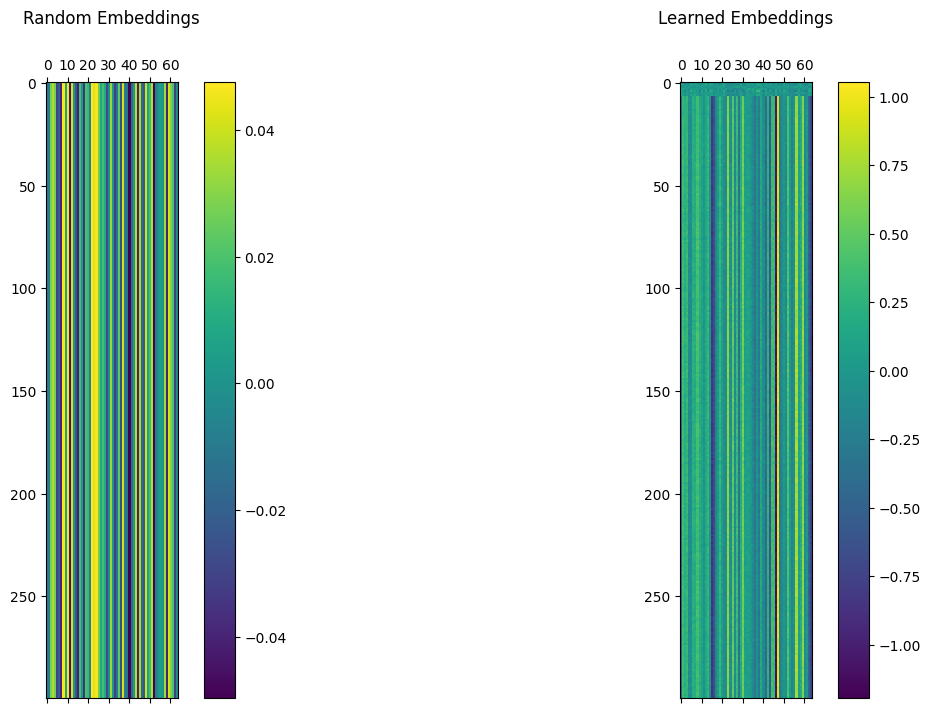

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dense, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MultiHeadAttention

from tensorflow.keras.preprocessing.text import Tokenizer

# Define a function to extract random embeddings from the EmbeddingLayer
def extract_random_embeddings(sequence_length, vocab_size, embed_dim, sample_input):
    # Define the random embedding layer (not trained, initialized randomly)
    input_layer = Input(shape=(sequence_length,))  # Define an input layer
    random_embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=sequence_length)(input_layer) # Call the embedding layer with the input
    random_embeddings_model = Model(inputs=input_layer, outputs=random_embedding_layer) # Define the model with input and output

    # Predict the random embeddings for the input sample
    random_embedding = random_embeddings_model.predict(sample_input)
    return random_embedding[0, :, :]

# Define a function to extract learned embeddings from the transformer model
def extract_learned_embeddings(transformer_model, sequence_length, sample_input):
    # Get the embeddings from the trained transformer model
    learned_embeddings_model = Model(inputs=transformer_model.input, outputs=transformer_model.layers[1].output) # Access the EmbeddingLayer (index 1)
    learned_embedding = learned_embeddings_model.predict(sample_input)
    # Check the shape of learned_embedding and adjust indexing accordingly
    print("Shape of learned_embedding:", learned_embedding.shape)  # Print the shape for debugging
    if learned_embedding.ndim == 3:
        return learned_embedding[0, :, :]
    elif learned_embedding.ndim == 2:
        return learned_embedding  # Return as is if 2D
    else:
        raise ValueError("Unexpected shape of learned_embedding")

# Select a sample input (here we use a single sample from the train data)
sample_input = X_train[:1]  # Adjust based on your training data

# Set the parameters (ensure they match your model parameters)
sequence_length = X_train.shape[1]  # e.g., 50 or your actual sequence length
# Recalculate vocab_size using tokenizer
tokenizer = Tokenizer(num_words=vocab_size) # Assuming 'vocab_size' is defined elsewhere
vocab_size = len(tokenizer.word_index) + 1  # Adjust based on your tokenizer

embed_dim = 64  # Same as defined in your model

# Extract random and learned embeddings
random_embedding = extract_random_embeddings(sequence_length, vocab_size, embed_dim, sample_input)
learned_embedding = extract_learned_embeddings(transformer_model, sequence_length, sample_input)

# Visualize the random and learned embeddings
fig = plt.figure(figsize=(15, 8))

# Plot Random Embeddings
ax = plt.subplot(1, 2, 1)
cax = ax.matshow(random_embedding, cmap='viridis')
plt.gcf().colorbar(cax)
plt.title('Random Embeddings', y=1.05, pad=20)

# Plot Learned Embeddings
ax = plt.subplot(1, 2, 2)
cax = ax.matshow(learned_embedding, cmap='viridis')
plt.gcf().colorbar(cax)
plt.title('Learned Embeddings', y=1.05, pad=20)

plt.show()

### Evaluate the Model

In [13]:
# Evaluate on validation set
val_metrics = transformer_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_metrics[1]:.4f}")


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8896 - loss: 0.4431
Validation Accuracy: 0.8850


### Plot Training History

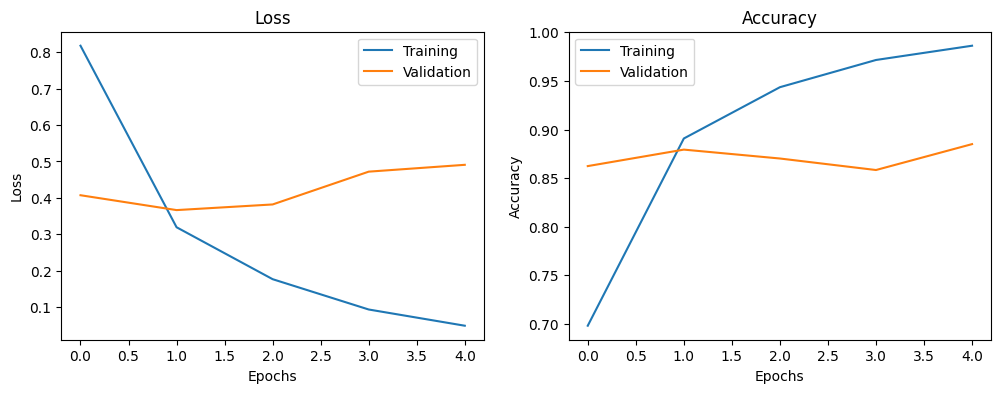

In [14]:
# Plot metrics
plt.figure(figsize=(12, 4))
for idx, metric in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, idx+1)
    plt.plot(history.history[metric], label='Training')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
plt.show()


### Confusion Matrix

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


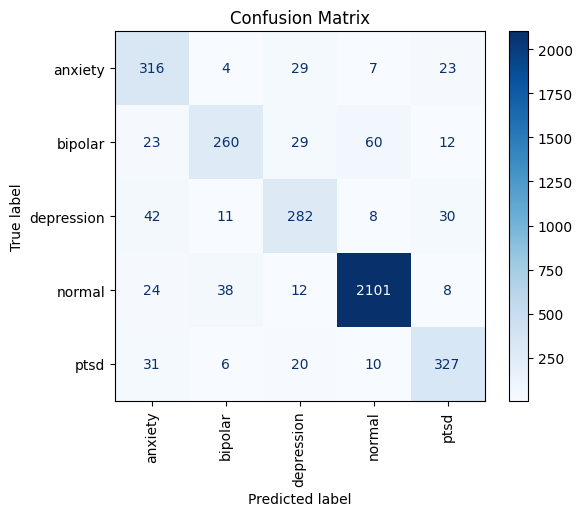

In [15]:
# Predictions
y_pred = transformer_model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### ROC AUC Curve

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


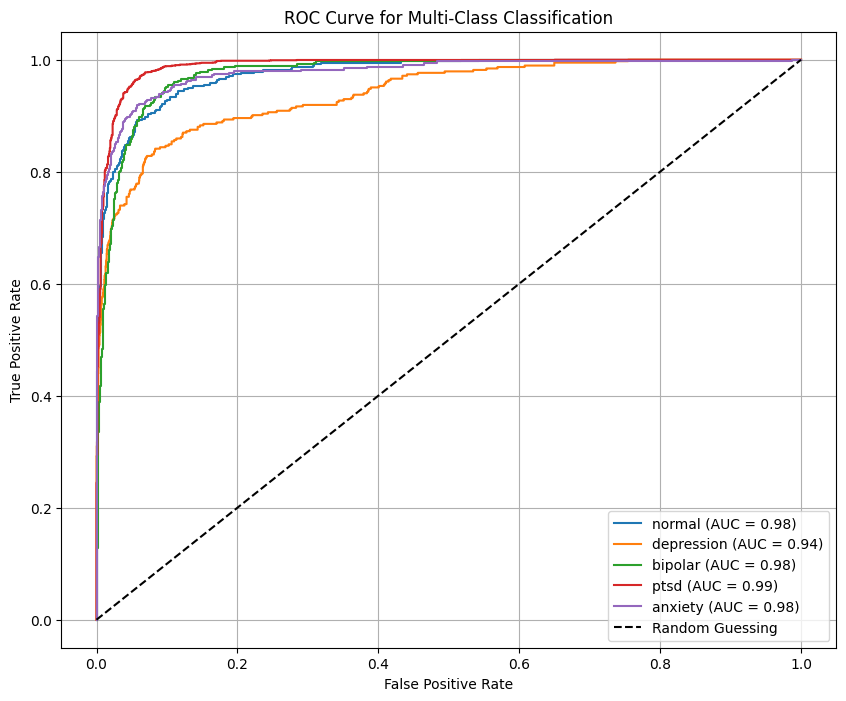

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true_labels, classes=np.arange(len(class_names)))

# Get the predicted probabilities for each class (softmax output)
y_pred_probs = transformer_model.predict(X_val)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

# Iterate over all the classes
for i in range(len(class_names)):
    # Compute ROC curve and ROC AUC for each class
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Configure the plot
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


### Get the pickle files

In [31]:
import pickle

# Save the transformer model (trained model)
with open('transformer_model.pkl', 'wb') as model_file:
    pickle.dump(transformer_model, model_file)
    print("Model saved as transformer_model.pkl")

# Save the vectorizer (TextVectorization layer)
with open('vectorize_layer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorize_layer, vectorizer_file)
    print("Vectorizer saved as vectorize_layer.pkl")

# Save the label encoder (for class label conversion)
with open('label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)
    print("Label Encoder saved as label_encoder.pkl")

# Optionally, save the training history (for analysis)
with open('training_history.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)
    print("Training history saved as training_history.pkl")


Model saved as transformer_model.pkl
Vectorizer saved as vectorize_layer.pkl
Label Encoder saved as label_encoder.pkl
Training history saved as training_history.pkl
